In [7]:
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

In [2]:
# 声明数据集文件位置
datafile = './mnist .json.gz'
# print('loading mnist data from{}'.format(datafile))
data = json.load(gzip.open(datafile))
# 划分数据集
train_set, val_set, eval_set = data

# 观察数据
imgs, labels = train_set[0], train_set[1]
print("训练集数量", len(imgs))

训练集数量 50000


In [3]:
imgs, labels = train_set[0], train_set[1]
print("训练集数量：", len(imgs))
# 获得数据集的长度
imgs_length = len(imgs)
# 给编号
index_list = list(range(imgs_length))
BATCHSIZE = 100

# 随机打乱序号
random.shuffle(index_list)

# 定义数据生成器，返回批次数据
def data_generator():
    imgs_list = []
    labels_list = []
    for i in index_list:
        img = np.array(imgs[i]).astype('float32')
        label = np.array(labels[i]).astype('float32')
        imgs_list.append(img)
        labels_list.append(label)
        if len(labels_list) == BATCHSIZE:
            yield np.array(imgs_list), np.array(labels_list)
            # 清空，为下一次循环做准备
            imgs_list = []
            labels_list = []
    # 还要考虑到最后一组少于BATCHSIZE
    if len(imgs_list) > 0:
        yield np.array(imgs_list), np.array(labels_list)
    return data_generator
   

训练集数量： 50000


In [4]:
# 读取数据
train_loader = data_generator
# 以迭代方式读取数据
for batch_id, data in enumerate(train_loader()):
    img_data, label_data = data
    if batch_id == 0:
        print("打印第一个batch的维度")
        print(f'图像维度{img_data.shape},标签维度{label_data.shape}')
        # print("打印第一组数据：")
        # print(f"第一个数据{img_data[0]},标签{label_data[0]}")
    break

打印第一个batch的维度
图像维度(100, 784),标签维度(100,)


In [5]:

imgs_length = len(imgs)

assert len(imgs) == len(labels), \
        "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))

In [6]:
# 声明数据读取函数，从训练集中读取数据
train_loader = data_generator
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    if batch_id == 0:
        # 打印数据shape和类型
        print("打印第一个batch数据的维度，以及数据的类型:")
        print("图像维度: {}, 标签维度: {}, 图像数据类型: {}, 标签数据类型: {}".format(image_data.shape, label_data.shape, type(image_data), type(label_data)))
    break

打印第一个batch数据的维度，以及数据的类型:
图像维度: (100, 784), 标签维度: (100,), 图像数据类型: <class 'numpy.ndarray'>, 标签数据类型: <class 'numpy.ndarray'>


In [7]:
def load_data(mode='train'):
    datafile = './mnist .json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')
   
    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data
    if mode=='train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode=='eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")
    print("训练数据集数量: ", len(imgs))
    
    # 校验数据
    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
    
    # 获得数据集长度
    imgs_length = len(imgs)
    
    # 定义数据集每个数据的序号，根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的批次大小
    BATCHSIZE = 100
    
    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            # 训练模式下打乱数据
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            # 将数据处理成希望的类型
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个batchsize的数据，并返回
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []
    
        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

In [5]:
# 完成了数据处理，这里就要完成神经网络的封装
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 定义一层全连接层
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)
    
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

In [9]:
def train(model):
    model.train()
    # 加载数据
    train_loader = load_data('train')
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels)
            
            # 前向
            predits = model(images)

            # 计算损失
            loss = F.square_error_cost(predits, labels)
            avg_loss = paddle.mean(loss)

            # 每训练200，记录一下
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            # 反向传播梯度
            avg_loss.backward()
            opt.step
            opt.clear_grad()
    
    # 保存模型
    paddle.save(model.state_dict(), '/my_ans1.pdparams')

model = MNIST()
train(model)

loading mnist dataset from ./mnist .json.gz ......
mnist dataset load done
训练数据集数量:  50000
epoch: 0, batch: 0, loss is: [33.07519]
epoch: 0, batch: 200, loss is: [33.805256]
epoch: 0, batch: 400, loss is: [33.99412]
epoch: 1, batch: 0, loss is: [33.73275]
epoch: 1, batch: 200, loss is: [37.634518]
epoch: 1, batch: 400, loss is: [32.48315]
epoch: 2, batch: 0, loss is: [31.404474]
epoch: 2, batch: 200, loss is: [29.268883]
epoch: 2, batch: 400, loss is: [41.515484]
epoch: 3, batch: 0, loss is: [28.919003]
epoch: 3, batch: 200, loss is: [33.49728]
epoch: 3, batch: 400, loss is: [38.266552]
epoch: 4, batch: 0, loss is: [36.868553]
epoch: 4, batch: 200, loss is: [37.508316]
epoch: 4, batch: 400, loss is: [33.06626]
epoch: 5, batch: 0, loss is: [29.877546]
epoch: 5, batch: 200, loss is: [35.630623]
epoch: 5, batch: 400, loss is: [36.27742]
epoch: 6, batch: 0, loss is: [33.5398]
epoch: 6, batch: 200, loss is: [30.872108]
epoch: 6, batch: 400, loss is: [31.63062]
epoch: 7, batch: 0, loss is: [

In [1]:
import json
import gzip
import paddle
from paddle.vision.transforms import Normalize
from paddle.io import Dataset
# 图像归一化，CHW,C通道数，H图像高度，W图像宽度，mean归一化均值，std标准差
transform = Normalize(mean=[127.5],std=[127.5], data_format='CHW')

class MNISTDataset(Dataset):
    """
    一、继承paddle.io.Dataset
    """

    def __init__(self, datafile, mode='train', transform = None):
        super().__init__()

        self.mode = mode
        self.transform = transform

        print('loading mnist dataset from {} ......'.format(datafile))
        # 加载json
        data = json.load(gzip.open(datafile))
        print('mnist dataset load done')

        # 读取测试集
        train_set, val_set, eval_set = data 

        if mode=='train':
            # 获得训练数据集
            self.imgs, self.labels = train_set[0], train_set[1]
        elif mode=='valid':
            # 获得验证数据集
            self.imgs, self.labels = val_set[0], val_set[1]
        elif mode=='test':
            # 获得测试数据集
            self.imgs, self.labels = eval_set[0], eval_set[1]
        else:
            raise Exception("mode can only be one of ['train', 'valid', 'test']")
    
    def __getitem__(self, idx):
        """步骤三：实现给定index获取数据"""
        data = self.imgs[idx]
        label = self.labels[idx]

        return self.transform(data), label
    
    def __len__(self):
        return len(self.imgs)

datafile = './mnist .json.gz'

# 下载数据集，初始化Dataset
train_dataset = MNISTDataset(datafile, mode='train', transform=transform)
test_dataset = MNISTDataset(datafile, mode='test', transform=transform)


print('train images: ', train_dataset.__len__(), ', test images: ', test_dataset.__len__())


loading mnist dataset from ./mnist .json.gz ......
mnist dataset load done
loading mnist dataset from ./mnist .json.gz ......
mnist dataset load done
train images:  50000 , test images:  10000


shape of image: (1, 1, 784)


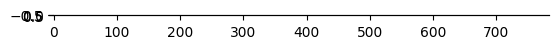

In [2]:
from matplotlib import pyplot as plt

for data in train_dataset:
    image, label = data
    print('shape of image:', image.shape)
    plt.imshow(image[0])
    break

In [3]:
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True,
                                    num_workers=1,
                                    drop_last=True)
print('step_num',len(train_loader))

step_num 781


e:\SoftWare\Program\Anaconda\envs\d2l\lib\site-packages\paddle\fluid\reader.py:486: UserWarning: DataLoader with multi-process mode is not supported on MacOs and Windows currently. Please use signle-process mode with num_workers = 0 instead
  warnings.warn(


In [8]:
def train(model):
    print('train:')
    model.train()
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 3
    for epoch_id in range(EPOCH_NUM):
        print('epoch:',epoch_id)
        for batch_id, data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images).astype('float32')
            labels = paddle.to_tensor(labels).astype('float32')
            
            images = paddle.reshape(images, [images.shape[0], images.shape[2]*images.shape[3]])

            #前向计算的过程  
            predicts = model(images)

            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)       
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')

#创建模型
print("create model:")
model = MNIST()
#启动训练过程
train(model)


create model:
train:
epoch: 0
epoch: 0, batch: 0, loss is: [28.963089]
epoch: 0, batch: 200, loss is: [10.312137]
epoch: 0, batch: 400, loss is: [7.9823866]
epoch: 0, batch: 600, loss is: [8.595398]
epoch: 1
epoch: 1, batch: 0, loss is: [9.324613]
epoch: 1, batch: 200, loss is: [8.283629]
epoch: 1, batch: 400, loss is: [8.021423]
epoch: 1, batch: 600, loss is: [9.139951]
epoch: 2
epoch: 2, batch: 0, loss is: [9.6273365]
epoch: 2, batch: 200, loss is: [11.402241]
epoch: 2, batch: 400, loss is: [8.920477]
epoch: 2, batch: 600, loss is: [9.324926]


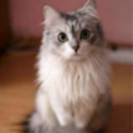

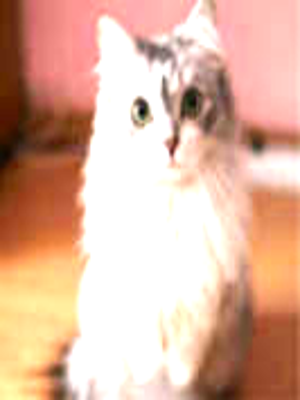

In [12]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import functional as F

img_path = './cat.jpg'
img = Image.open(img_path)

new_img = F.adjust_brightness(img, 2.0)

display(img)
display(new_img.resize((300,400)))

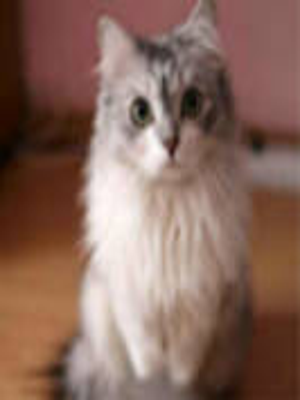

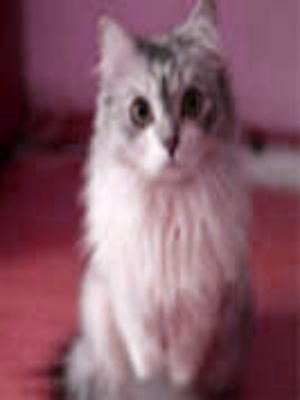

In [21]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import functional as F

img_path = "./cat.jpg"

image=Image.open(img_path)

# adjust_hue对输入图像进行色调的调整
new_img=F.adjust_hue(image, -0.1)

# 显示图像
display(image.resize((300,400)))
display(new_img.resize((300,400)))

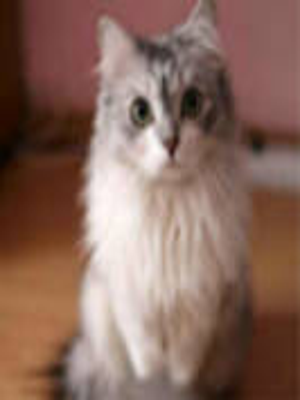

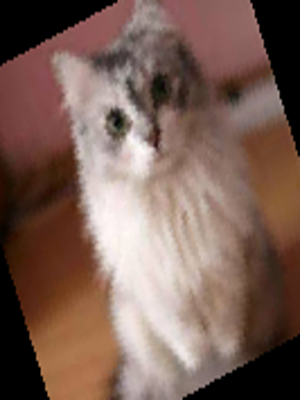

In [24]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import RandomRotation

img_path = "./cat.jpg"

image=Image.open(img_path)

# RandomRotation依据90度，按照均匀分布随机产生一个角度对图像进行旋转
transform = RandomRotation(30)

new_img = transform(image)

# 显示图像
display(image.resize((300,400)))
display(new_img.resize((300,400)))